## Import all the libraries and dependencies

In [1]:

import numpy as np
import os
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential



In [2]:
import matplotlib.pyplot as plt
import PIL

hi


In [3]:
import pathlib

In [4]:
dataset_url = dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

In [5]:
data_dir = tf.keras.utils.get_file('flower_photos' , origin =dataset_url, untar=True)

In [6]:
data_dir = pathlib.Path(data_dir)


In [7]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


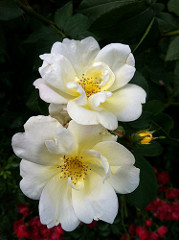

In [8]:
roses = list(data_dir.glob('roses/*'))
tulips = list(data_dir.glob('tulips/*'))
daisy = list(data_dir.glob('daisy/*'))
PIL.Image.open(str(roses[0]))

In [9]:
def open_roses_images(index):
	return PIL.Image.open(str(roses[index]))


def open_tulips_images(index):
	return PIL.Image.open(str(tulips[index]))


def open_daisy_images(index):
	return PIL.Image.open(str(daisy[index]))

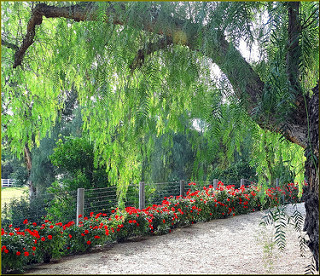

In [10]:
open_roses_images(5)

In [11]:
print(len(roses))

641


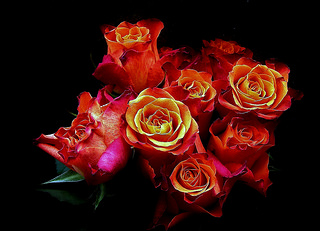

In [12]:
open_roses_images(39)

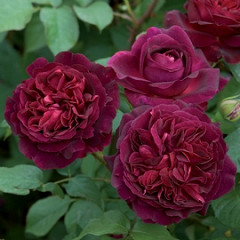

In [13]:
open_roses_images(600)

## Batch size

number of samples before updating the model parameters



In [14]:
batch_size = 32
img_height = 180
img_width=  180

In [15]:
validation_split = 0.2
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
data_dir,
	validation_split= validation_split,
	subset='training',
	seed=123,
	image_size=(img_height, img_width),
	batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [16]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=validation_split,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)



Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [17]:
train_ds.class_names
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## All the class names to the dataset


In [18]:
for image_batch, label_batch in train_ds:
	print('The following means 32 images with 180 width and height and 3 colors in those images')
	print(image_batch.shape)
	break

The following means 32 images with 180 width and height and 3 colors in those images
(32, 180, 180, 3)


In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [20]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

### Normalization of  the data to follow the normal distirbution the gausian

In [21]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0143791055 0.9679742


In [22]:
number_of_classes = 5
number_of_colors_in_images = 3
cnn_model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, number_of_colors_in_images)),
  layers.Conv2D(8, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(number_of_classes)
])

more here --> https://stats.stackexchange.com/questions/296679/what-does-kernel-size-mean/339265#:~:text=The%20kernel%20size%20here%20refers,within%20a%20mask%20(kernel).&text=kernel_size%3A%20An%20integer%20or%20tuple,of%20the%202D%20convolution%20window.
Deep neural networks, more concretely convolutional neural networks (CNN), are basically a stack of layers which are defined by the action of a number of filters on the input. Those filters are usually called kernels.

For example, the kernels in the convolutional layer, are the convolutional filters. Actually no convolution is performed, but a cross-correlation. The kernel size here refers to the widthxheight of the filter mask.

The max pooling layer, for example, returns the pixel with maximum value from a set of pixels within a mask (kernel). That kernel is swept across the input, subsampling it.

So nothing to do with the concept of kernels in support vector machines or regularization networks. You can think of them as feature extractors.

In [23]:
cnn_model.compile(optimizer='adam' ,
                  loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy']
                  )


In [24]:
cnn_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 32)        0

In [25]:
epochs=10
history = cnn_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 59s 589ms/step - loss: 1.4907 - accuracy: 0.3047 - val_loss: 1.1635 - val_accuracy: 0.5300

### Prediction in a new data

In [26]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = cnn_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to sunflowers with a 100.00 percent confidence.


In [27]:
from PIL import Image

In [28]:
image_rose_example1 = open_roses_images(600)
image_rose_example1 = image_rose_example1.resize((180, 180), 3)
img_array2 = keras.preprocessing.image.img_to_array(image_rose_example1)
img_array2 = tf.expand_dims(img_array2, 0) # Create a batch

predictions2 = cnn_model.predict(img_array2)
score = tf.nn.softmax(predictions2[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to roses with a 78.87 percent confidence.


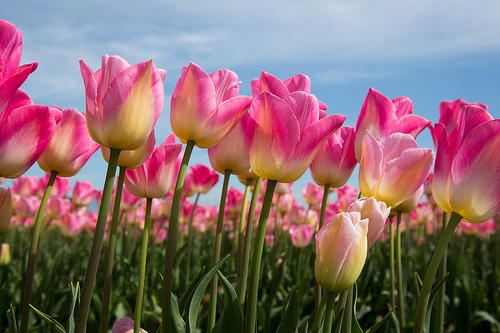

In [29]:
open_tulips_images(3)


In [30]:
def transform_image_dimension(n):
	image_example = open_roses_images(n)
	image_example = image_example.resize((180, 180), 3)
	img_in_array_format = keras.preprocessing.image.img_to_array(image_example)
	img_in_array_format = tf.expand_dims(img_in_array_format, 0)
	return img_in_array_format

In [31]:
from random import randrange
n = randrange(0,599)
print(n)
transform_image_dimension(n)




366


<tf.Tensor: shape=(1, 180, 180, 3), dtype=float32, numpy=
array([[[[ 51.,  43.,  38.],
         [ 72.,  69.,  59.],
         [ 88.,  85.,  72.],
         ...,
         [ 43.,  32.,   6.],
         [ 15.,   7.,   9.],
         [  2.,   6.,   3.]],

        [[ 74.,  76.,  57.],
         [ 87.,  81.,  61.],
         [112., 103.,  85.],
         ...,
         [  6.,   6.,   9.],
         [ 36.,  15.,   7.],
         [ 38.,  21.,  12.]],

        [[160., 151.,  80.],
         [221., 207., 125.],
         [158., 140.,  84.],
         ...,
         [  0.,   0.,   9.],
         [ 32.,  22.,  10.],
         [ 65.,  43.,  19.]],

        ...,

        [[ 58.,  58.,  46.],
         [ 58.,  58.,  46.],
         [ 56.,  56.,  44.],
         ...,
         [ 55.,  57.,  46.],
         [ 62.,  64.,  53.],
         [ 54.,  56.,  45.]],

        [[ 57.,  57.,  45.],
         [ 59.,  59.,  47.],
         [ 60.,  60.,  48.],
         ...,
         [ 61.,  63.,  52.],
         [ 59.,  61.,  50.],
         

In [32]:
cnn_model.save('image-classification.h5')


In [33]:
new_model = tf.keras.models.load_model('image-classification.h5')